In [3]:
import numpy as np
import pandas as pd
import os 
import tensorflow as tf
import tensorflow.keras as keras
from keras import Model
from keras.applications.densenet import DenseNet121
from keras.applications import vgg16
from keras.preprocessing import image
from keras.applications.densenet import preprocess_input, decode_predictions
from keras.layers import GlobalMaxPooling2D
from tensorflow.keras.utils import plot_model

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import pathlib
from sklearn.metrics.pairwise import linear_kernel

# Data Preparation

In [8]:
path = 'C:/Users/jaich/Downloads/Fashion-Recommendation-System-main/Fashion-Recommendation-System-main/fashion_small/'
dataset_path = pathlib.Path(path)
dirs_names = os.listdir(dataset_path) # list content of dataset
dirs_names

['images']

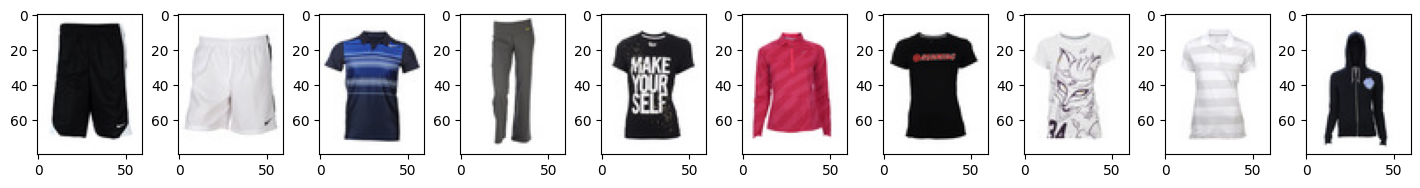

In [9]:
# Plot samples 
plt.figure(figsize=(20,20))
for i in range(20,30):
    plt.subplot(6, 10, i-10+1)
    cloth_img =  mpimg.imread(path + 'images/100' + str(i) +'.jpg') # Assign images ids
    plt.imshow(cloth_img)
plt.subplots_adjust(wspace=-0.5, hspace=1)
plt.show()

In [24]:
styles_df = pd.read_csv(path + "styles.csv", nrows=6000, on_bad_lines='skip') # Read 6000 product and drop bad lines 
styles_df['image'] = styles_df.apply(lambda x: str(x['id']) + ".jpg", axis=1) # Make image column contains (id.jpg)
image_dir = "C:/Users/jaich/Downloads/Fashion-Recommendation-System-main/Fashion-Recommendation-System-main/fashion_small/images/" 
styles_df['image'] = styles_df['image'].apply(lambda x: os.path.join(image_dir, x))

print(styles_df.shape)
styles_df.head(10)

(6000, 11)


,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName,image
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011,Casual,Turtle Check Men Navy Blue Shirt,C:/Users/jaich/Downloads/Fashion-Recommendatio...
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012,Casual,Peter England Men Party Blue Jeans,C:/Users/jaich/Downloads/Fashion-Recommendatio...
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016,Casual,Titan Women Silver Watch,C:/Users/jaich/Downloads/Fashion-Recommendatio...
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011,Casual,Manchester United Men Solid Black Track Pants,C:/Users/jaich/Downloads/Fashion-Recommendatio...
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012,Casual,Puma Men Grey T-shirt,C:/Users/jaich/Downloads/Fashion-Recommendatio...
5,1855,Men,Apparel,Topwear,Tshirts,Grey,Summer,2011,Casual,Inkfruit Mens Chain Reaction T-shirt,C:/Users/jaich/Downloads/Fashion-Recommendatio...
6,30805,Men,Apparel,Topwear,Shirts,Green,Summer,2012,Ethnic,Fabindia Men Striped Green Shirt,C:/Users/jaich/Downloads/Fashion-Recommendatio...
7,26960,Women,Apparel,Topwear,Shirts,Purple,Summer,2012,Casual,Jealous 21 Women Purple Shirt,C:/Users/jaich/Downloads/Fashion-Recommendatio...
8,29114,Men,Accessories,Socks,Socks,Navy Blue,Summer,2012,Casual,Puma Men Pack of 3 Socks,C:/Users/jaich/Downloads/Fashion-Recommendatio...
9,30039,Men,Accessories,Watches,Watches,Black,Winter,2016,Casual,Skagen Men Black Watch,C:/Users/jaich/Downloads/Fashion-Recommendatio...


<Axes: ylabel='articleType'>

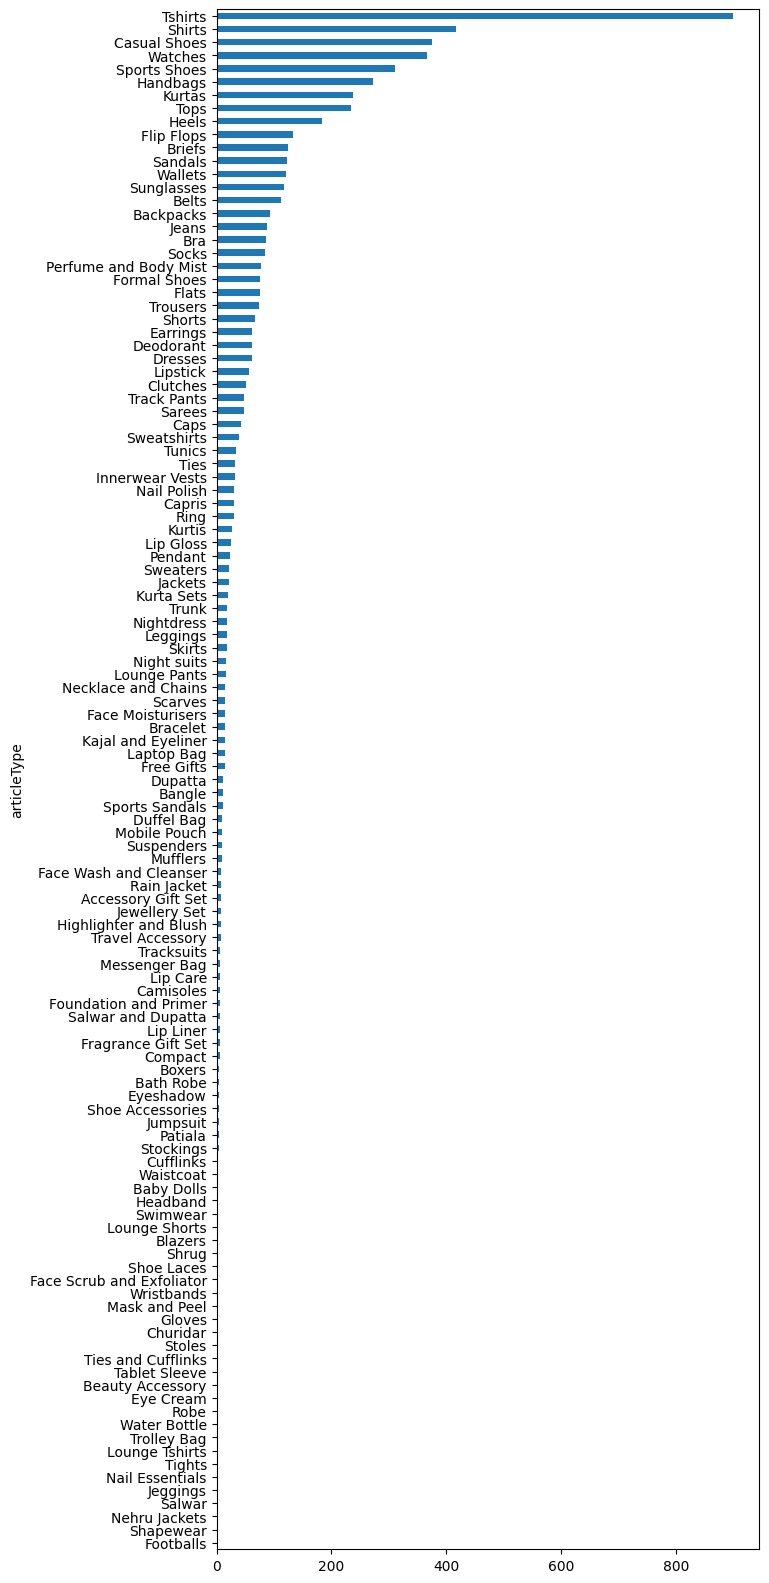

In [25]:
plt.figure(figsize=(7,20))
styles_df.articleType.value_counts().sort_values().plot(kind='barh')

# Modeling and Get Image Embeddings

In [26]:
img_width, img_height, chnls = 100, 100, 3

In [27]:
from tensorflow.keras.applications import VGG16

In [28]:
#VGG16
from tensorflow.keras.applications import VGG16

vgg16 = VGG16(include_top=False, weights='imagenet', input_shape=(img_width, img_height, chnls))
vgg16.trainable=False
vgg16_model = keras.Sequential([vgg16, GlobalMaxPooling2D()])
vgg16_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 3, 3, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling2d_1          │ (None, 512)            │             0 │
│ (GlobalMaxPooling2D)            │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

In [29]:
def img_path(img):
    """ Take image name(id) and return the complete path of it """
    return path + 'images/' + img

def predict(model, img_name):
    """ Load and preprocess image then make prediction """
    # Reshape
    img = image.load_img(img_path(img_name), target_size=(img_width, img_height))
#     img = image.load_img(os.path.join(path, "images", img_name), target_size=(img_width, img_height))
    # img to Array
    img = image.img_to_array(img)
    # Expand Dim (1, w, h)
    img = np.expand_dims(img, axis=0)
    # Pre process Input
    img = preprocess_input(img)
    return model.predict(img)

In [30]:
def get_embeddings_batch(df, model, batch_size=32):
    """Return a DataFrame of image features using batch processing."""
    image_paths = df['image'].tolist()
    embeddings = []

    for i in range(0, len(image_paths), batch_size):
        batch_paths = image_paths[i:i + batch_size]
        batch_images = []

        for img_path in batch_paths:
            try:
                img = image.load_img(img_path, target_size=(100, 100))
                img_array = image.img_to_array(img)
                batch_images.append(img_array)
            except Exception as e:
                print(f"Error loading image {img_path}: {e}")

        if batch_images:
            batch_images = np.array(batch_images)
            batch_images = preprocess_input(batch_images)
            batch_embeddings = model.predict(batch_images)
            embeddings.extend(batch_embeddings)

    return pd.DataFrame(embeddings)

df_embeddings = get_embeddings_batch(styles_df, vgg16_model)



1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 514ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

In [32]:
output_dir = "/kaggle/working"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

df_embeddings.to_csv(os.path.join(output_dir, "df_embeddings.csv"), index=False)

In [34]:
df_embeddings.head(5)

,0,1,2,3,4,5,6,7,8,9,...,502,503,504,505,506,507,508,509,510,511
0,0.000000,0.0,0.000000,0.000000,0.416762,0.000000,0.000000,0.0,0.0,0.0,...,0.465504,2.526568,0.000000,0.000000,0.023389,0.256390,0.000000,0.000000,0.663361,2.707127
1,0.656388,0.0,0.226174,0.000000,0.734097,0.000000,1.910262,0.0,0.0,0.0,...,1.004094,3.999026,0.000000,0.623049,0.519440,0.552859,1.366483,0.992331,0.629039,1.477583
2,0.113615,0.0,0.000000,1.226548,0.866502,0.000000,0.938749,0.0,0.0,0.0,...,1.014140,0.170607,0.000000,0.115413,0.141612,0.493683,0.078028,0.000000,1.143076,0.000000
3,0.000000,0.0,0.000000,0.000000,0.614342,0.000000,0.848840,0.0,0.0,0.0,...,1.126509,2.467212,0.124418,0.000000,0.000000,0.192454,0.507868,0.000000,0.111597,2.579832
4,0.000000,0.0,0.000000,0.000000,0.096241,0.220482,0.000000,0.0,0.0,0.0,...,0.163552,0.334456,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.044779,2.458955


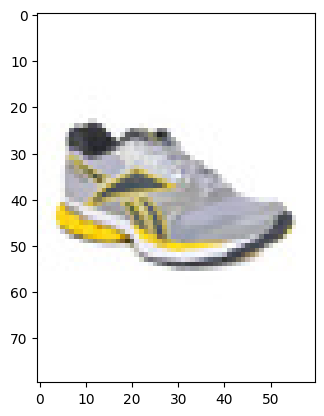

In [35]:
url="C:/Users/jaich/Downloads/Fashion-Recommendation-System-main/Fashion-Recommendation-System-main/fashion_small/images/10037.jpg"
a = plt.imread(url)
plt.imshow(a)

In [36]:
sample_image = predict(vgg16_model, '10004.jpg')
sample_image.shape

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


(1, 512)

In [37]:
df_sample_image = pd.DataFrame(sample_image)  
print(df_sample_image)

       0    1    2    3         4    5         6    7    8         9    ...  \
0  0.58663  0.0  0.0  0.0  1.410702  0.0  1.325351  0.0  0.0  0.461283  ...   

        502       503       504       505  506       507  508       509  \
0  1.364411  0.655589  0.080286  0.145577  0.0  0.355455  0.0  0.597835   

        510  511  
0  0.196405  0.0  

[1 rows x 512 columns]


In [38]:
sample_similarity = linear_kernel(df_sample_image, df_embeddings)
print(sample_similarity)

[[250.78293 376.6459  260.38058 ... 312.4237  290.03513 283.66257]]


In [39]:
def get_similarity(model):
    """ Get similarity of custom image """
    sample_image = predict(vgg16_model, '10004.jpg')
    df_sample_image = pd.DataFrame(sample_image)
    sample_similarity = linear_kernel(df_sample_image, df_embeddings)
    return sample_similarity

In [40]:
def normalize_sim(similarity):
    """ Normalize similarity results """
    x_min = similarity.min(axis=1)
    x_max = similarity.max(axis=1)
    norm = (similarity-x_min)/(x_max-x_min)[:, np.newaxis]
    return norm

sample_similarity_norm = normalize_sim(sample_similarity)
sample_similarity_norm.shape

(1, 6000)

In [41]:
def get_recommendations(df, similarity):
    """ Return the top 5 most similar products """
    # Get the pairwsie similarity scores of all clothes with that one (index, value)
    sim_scores = list(enumerate(similarity[0]))
    
    # Sort the clothes based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    
    # Get the scores of the 5 most similar clothes
    sim_scores = sim_scores[0:5]
    print(sim_scores)
    # Get the clothes indices
    cloth_indices = [i[0] for i in sim_scores]

    # Return the top 5 most similar products
    return df['image'].iloc[cloth_indices]

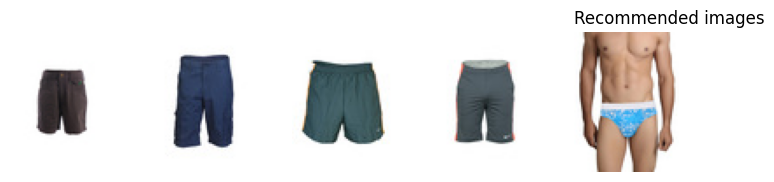

In [43]:
plt.figure(figsize=(20, 20))
j = 0

for i in recommendation_list:
    # Extract image filename if necessary
    image_name = os.path.basename(i)
    
    # Construct the full path to the image
    img_path = os.path.join(path, 'images', image_name)
    
    try:
        # Load and display the image
        cloth_img = mpimg.imread(img_path)
        plt.subplot(6, 10, j+1)
        plt.imshow(cloth_img)
        plt.axis("off")
        j += 1
    except Exception as e:
        print(f"Error loading image {image_name}: {e}")

plt.title("Recommended images", loc='left')
plt.subplots_adjust(wspace=-0.5, hspace=1)
plt.show()

# Reusable class for production

In [57]:
import numpy as np
import pandas as pd
import os 
import tensorflow as tf
import tensorflow.keras as keras
from keras import Model
from keras.applications.densenet import DenseNet121
from tensorflow.keras.applications import VGG16
from keras.preprocessing import image
from keras.applications.densenet import preprocess_input, decode_predictions
from keras.layers import GlobalMaxPooling2D
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import pathlib
from sklearn.metrics.pairwise import linear_kernel

class fashion_recommendations:
    """ Production class for recommendations of fashion from similarity """
    
    def __init__(self, img_path, df_embeddings, styles_path):
        self.img_path = img_path
        self.df_embeddings = df_embeddings
        self.styles_path = styles_path
    # Helper functions 
    def get_styles_df(self):
        """ Load a dataframe contains styles details and images """
        styles_df = pd.read_csv(self.styles_path, nrows=6000, on_bad_lines='skip')  # Read 6000 product and drop bad lines
        styles_df['image'] = styles_df.apply(lambda x: str(x['id']) + ".jpg", axis=1) # Make image column contains (id.jpg)
        return styles_df
    
    def load_model(self):
        """ Load our model """
        vgg16 = VGG16(include_top=False, weights='imagenet', input_shape=(100, 100, 3))
        vgg16.trainable=False
        vgg16_model = keras.Sequential([vgg16, GlobalMaxPooling2D()])
        return vgg16_model

    def predict(self, model, img_path):
        """ Load and preprocess image then make prediction """
        # Reshape
        img = image.load_img(self.img_path, target_size=(100, 100)) # đoạn này có thể chuyển thành tải ảnh theo link về
        # img to Array
        img = image.img_to_array(img)
        # Expand Dim (1, w, h)
        img = np.expand_dims(img, axis=0)
        # Pre process Input
        img = preprocess_input(img)
        return model.predict(img)
    
    def get_similarity(self):
        """ Get similarity of custom image """
        model = self.load_model()
        df_embeddings = self.df_embeddings
        sample_image = self.predict(model, self.img_path)
        df_sample_image = pd.DataFrame(sample_image)
        sample_similarity = linear_kernel(df_sample_image, df_embeddings)
        return sample_similarity
    
    def normalize_sim(self):
        """ Normalize similarity results """
        similarity = self.get_similarity()
        x_min = similarity.min(axis=1)
        x_max = similarity.max(axis=1)
        norm = (similarity-x_min)/(x_max-x_min)[:, np.newaxis]
        return norm
    
    def get_recommendations(self):
        """ Get recommended images """
        similarity = self.normalize_sim()
        df = self.get_styles_df()
        # Get the pairwsie similarity scores of all clothes with that one (index, value)
        sim_scores = list(enumerate(similarity[0]))

        # Sort the clothes based on the similarity scores
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

        # Get the scores of the 5 most similar clothes
        sim_scores = sim_scores[0:5]
        print(sim_scores)
        # Get the clothes indices
        cloth_indices = [i[0] for i in sim_scores]

        # Return the top 5 most similar products
        return df['image'].iloc[cloth_indices]
    
    def print_recommendations(self):
        """ Print the top 5 most similar products"""
        recommendation = self.get_recommendations()
        recommendation_list = recommendation.to_list()
        #recommended images
        plt.figure(figsize=(20,20))
        j=0
        for i in recommendation_list:
            plt.subplot(6, 10, j+1)
            cloth_img =  mpimg.imread("C:/Users/jaich/Downloads/Fashion-Recommendation-System-main/Fashion-Recommendation-System-main/fashion_small/" + 'images/'+ i) # Đoạn này trả về id là được
            plt.imshow(cloth_img)
            plt.axis("off")
            j+=1
        plt.title("Recommended images",loc='left')
        plt.subplots_adjust(wspace=-0.5, hspace=1)
        plt.show()
        return 

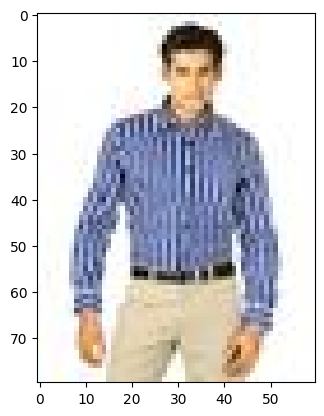

In [47]:
url = "C:/Users/jaich/Downloads/Fashion-Recommendation-System-main/Fashion-Recommendation-System-main/fashion_small/images/10188.jpg"
a = plt.imread(url)
plt.imshow(a)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
[(5414, np.float32(1.0)), (4777, np.float32(0.87772137)), (1581, np.float32(0.87186563)), (2951, np.float32(0.85660106)), (3841, np.float32(0.8304357))]


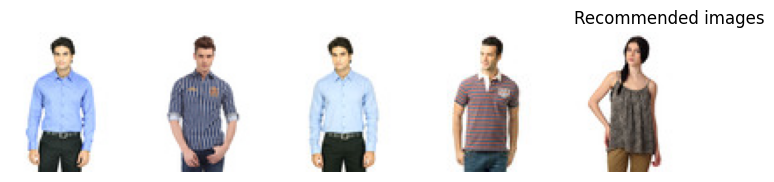

In [58]:

img_path = 'C:/Users/jaich/Downloads/Fashion-Recommendation-System-main/Fashion-Recommendation-System-main/fashion_small/images/10188.jpg'
styles_path = 'C:/Users/jaich/Downloads/Fashion-Recommendation-System-main/Fashion-Recommendation-System-main/fashion_small/styles.csv'
obj = fashion_recommendations(img_path, df_embeddings, styles_path)
obj.print_recommendations()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
[(0, np.float32(nan))]


C:\Users\jaich\AppData\Local\Temp\ipykernel_8196\713128991.py:66: RuntimeWarning: invalid value encountered in divide
  norm = (similarity-x_min)/(x_max-x_min)[:, np.newaxis]


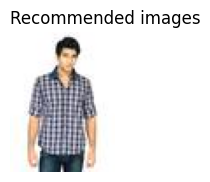

In [59]:
img_path = 'C:/Users/jaich/Downloads/Fashion-Recommendation-System-main/Fashion-Recommendation-System-main/fashion_small/images/10188.jpg'
styles_path = 'C:/Users/jaich/Downloads/Fashion-Recommendation-System-main/Fashion-Recommendation-System-main/fashion_small/styles.csv'
obj = fashion_recommendations(img_path, None, styles_path)
obj.print_recommendations()

In [60]:
model = obj.load_model()

# Lưu mô hình
model.save("/kaggle/working/AIShop_model.h5")
print("Model saved successfully!")

Model saved successfully!


In [61]:
import joblib

# Save the embeddings dataframe
joblib.dump(df_embeddings, 'df_embeddings.joblib')

# Save the model
vgg16_model.save('/kaggle/working/vgg16_model.h5')